<h1><p style="text-align: center">How Good are FIFA Ratings at Predicting Actual Results?</p></h1>

### Introduction
Every year, EA Sport releases a new rendition of its FIFA series, and every year I and 24 million other people flock to buy it. In the game, every player is assigned a rating between 0 and 100 based on their performances in the previous season. How specifically the ratings are calculated is somewhat opaque, but it involves some combination of performance statistics and subjective scout reports that are then reviewed by a team of editors at EA. 

In this notebook, I try and examine if these ratings are any good at predicting real match outcomes. To do this, I use match data from last year's premier league season (2017/18) and ratings from this year's game, FIFA 19. That gives me a base of 380 games to work with. For every game that was played last year, I use lineup information to compute the average rating for each team, and then find the difference. Then, since I know what the difference in rating was for each game and I know the result, I can effectively compute the probability distribution of outcomes for a game given the difference in average team rating. 

So how good are these ratings at predicting actual results? Turns out, not very. I used the distribution I estimated to see how many games I could correctly predict this season (the testing data) and I was right about 47% of the time. I got the same result when I simulated last season (the trainning data) based on my distribution estimate.

Now, while that is not great, it is at least better than randomly picking an outcome (win, draw, or loss). Theoretically, if you did that, you would be correct one-third of the time. My simulation results bore that out; random picking was 37% correct on the testing data and 32% correct on the training data.

The main contribution of this project are the datasets I compiled for this and last season. This was a lot more difficult than I had initially anticipated, but the code I wrote to extract real match data is quite robust and would be able to extract lineup and match information for every season going back to 1992 (and I intend to do this). I was unable to find a free dataset online that had this information, so I took this project as an oppertunity to learn how to web-scrape and do it myself.  

The rest of this notebook is broken into two parts. The first part details what's in the data, how I scraped it, and what trouble I ran into. The second part shows my analysis of FIFA scores and match outcomes in more detail and examines the limitations of this particular approach. 


### The Data 

In [1]:
# import libraries
import numpy as np 
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
import pandas as pd
import unidecode
import seaborn as sns
from scipy import stats
import math
import warnings

# set sns color code
sns.set(color_codes=True)

# suprress warnings, I'm doing this so the notebook is more readable
warnings.filterwarnings("ignore")

Instead of computing a squad average FIFA rating for each team, I decided to compute an average rating for the players who <i>actually played</i> in a given game. This is reasonable because if say Arsenal (a pretty good team) played their reserves against Crystal Palace's first eleven (a worse team), that would affect Crystal Palace's odds of winning.

I could not find a dataset that contained the score, lineups, and substitutes for a given game. The datasets I created have these fields. For a given match, I got this information directly from the Premier League website results page (https://premierleague.com/results/). Every game has a unique match ID associated with it. To access the details for that specific match, you just need to append the match ID to that URL. Then, since all the results pages are identically formatted, you can run the same script to extract data from them. 

To find the match ID for all the games in a season, you really just need to find the match ID for the first game. That is also available on the results page. I just scrolled down to the bottom of the page until I hit the first game of the 2017/18 season and then right-clicked, hit inspect, and saw the associated match ID. Since there are 380 games in a season (each of the 20 teams plays every other twice in a round-robin format), the last match ID is just the first one plus 379. I download and scrape the pages in turn. 

The four functions in the following hidden cell do the web-scraping.

In [2]:
# main functions used for scraping the premier league website

def remove_special_characters(name):
    """This function removes numbers, apostrophes, and addition signs from a string and returns the cleaned string. 
    This was specifically written with the format of name strings from the premier league match summaries in mind. 
    Strings of the form "john doe 90 + 4' " are returned as "john doe".
    
    :param str name: The full string of text containing the player name.
    :return: A string containing the name with the unnecessary characters stripped.
    :rtype: str 
    
    """
    for c in ['0','1','2','3','4','5','6','7','8','9','+',"'"]:
        name = name.replace(c,'')
    
    # remove trailing spaces
    name.strip()
    
    return name



def remove_team_code(name):
    """This function removes team codes from a string containing names+codes.
    The function is limited in that it only does this for teams that were involved in the premier league
    in the 2017/18 and 2018/19 seasons. 
    
    :param str name: A team name of the form name+code.
    :return: A string containing the team name with the codes removed i.e BurnleyBUR returns Burnley.
    :rtype: str
    
    """
    # team codes
    team_codes = ["BUR","BOU","CRY","WBA","HUD","ARS","LIV","BHA","MUN","WAT","NEW","CHE","SOU",\
                  "MCI","SWA","STK","TOT","LEI","WHU","EVE","WOL","CAR","FUL"]
    
    # look for codes in name, if found, remove
    for c in team_codes:
        name = name.replace(c,'')
        
    return name



def extract_epl_lineups(team_container, home):
    """This function extract lineups information from the matchLineupTeamContainer class 
    as defined on the the premier league results website. 
    
    :param Tag team_container: Contains the matchLineupTeamContainer from the premier league website.
    :param bool home: A flag for whether team_conatiner contains the home team lineup or away team lineup
    :return:  A dictionary with the keys = [ "player1", ...., "player 14"], and the values are [{"name":"John Doe"}....].
             If a team plays with less than 14 players in a game, the remaining slots are left blank (= '').
    :rtype: dict
    
    """
    
    # generate keys for return dict, initialize player names
    if home== True:
        base_string = "home_player"
    else: 
        base_string = "away_player"
    keys = [base_string+str(i+1) for i in range(14)]
    player_names = []

    # extract info from the container
    lineup_container = team_container.find_all("div",{"class":"info"})
    
    # extract player names
    for i in range(len(lineup_container)):
        if i < 11:
            player_names.append(unidecode.unidecode(remove_special_characters(lineup_container[i].div.text)))
        else:
            if lineup_container[i].div.div.text != '':
                player_names.append(unidecode.unidecode(remove_special_characters(lineup_container[i].div.text)))
    
    # create dictionary 
    player_dict = dict(zip(keys,player_names))
    
    # if player12, player13, or player14 don't exits, create and and assign '' as value
    for i in range(12,15):
        if base_string+str(i) not in player_dict:
            player_dict[base_string+str(i)]= ""
            
    return player_dict




def extract_epl_match_details(match_ids):
    """This function extracts match information for games from the premier league results website
    given their match ids. 
   
    :param list match_ids: A list of match ids for the games you're interested in. Can be a list of one or empty. 
    :return: A dictionary containing the match information for every match id. Each unique match
            match id is a key. The value is the corresponding match information which is a list 
            five dictionaries the team names, score, result (encoded as 1 for a home team win, 
            0 for a draw, -1 for an away team win), the home team lineup,
            and the away team line up. The dictionaries are formatted as follows:
            team_names = {"home_team":"Arsenal", "away_team":"Liverpool"}
            score = {"home_goals":2, "away_goals":3}
            result = {"result": 1}
            home_team = {"home_player1":"Petr Cech", ....., "home_player14": "Alex Iwobi"}
            away_team = {"away_player1":"Loris Karius", ...., "away_player14":""}
    :rtype: dict
    
    """
     
    # where the match data is being scraped from
    epl_url = "https://www.premierleague.com/match/"

    # initialize a dictionary to store the results 
    data = dict()

    # this loop extracts the data through each game in turn
    for match_id in match_ids:

        # url for each math
        match_url = epl_url + str(match_id)

        # download page, call and then close client
        uClient = uReq(match_url)
        results_page = uClient.read()
        uClient.close()

        # extract html
        results_soup = soup(results_page, "html.parser")

        # extract home team name container
        home_team_container = results_soup.findAll("div", {"class":"team home"})

        # extract away team name container
        away_team_container = results_soup.findAll("div", {"class":"team away"})

        # extract score container
        score_container = results_soup.findAll("div", {"class":"matchScoreContainer"})

         # extract lineup containers 
        team_lineups_container = results_soup.findAll("div", {"class":"matchLineupTeamContainer"})

        # extract team names from their containers
        team_names = {"home_team": remove_team_code(home_team_container[0].text),\
                      "away_team":remove_team_code(away_team_container[0].text)}

        # extract score from score container
        score = {"home_goals": int(((score_container[0].text).split("-"))[0]),\
                 "away_goals":int(((score_container[0].text).split("-"))[1]) }

        # use score to determine match outcome, Win for home team = 1, Win for away team = -1, draw = 0
        result = {"result":  1 if score["home_goals"] > score["away_goals"] else\
                  -1 if score["away_goals"] > score["home_goals"] else 0 }

        # extract lineups for the home and away team from their containers, this includes substitutes who made appearances
        home_team = extract_epl_lineups(team_lineups_container[0], home = True)
        away_team = extract_epl_lineups(team_lineups_container[1], home = False)

        # append to data dictionary
        data[match_id] = [team_names, score, result, home_team, away_team]

    return data



Finding a complete data set with consistent naming conventions turned out to be a lot more difficult than I expected. The data set I eventually settled I found on GitHub ("https://raw.githubusercontent.com/kafagy/fifa-FUT-Data/master/FIFA19.csv) most closely matched with the names on the Premier League website. Although I was able to match over 90% of the names using a combination of queries, I still could not get everything I needed from this dataset because some players retired between the release of the game and the end of last season, changed their preferred names, or were simply missing from this dataset.

This is why I created an auxiliary dataset with all the missing player ratings (https://github.com/shahzoor/FIFA_PROJECT). I used code to generate a list of names, but since the number of missing names was small enough, I just entered in their ratings manually. I uploaded the CSV file to my GitHub and read it in directly in the next section.

The two functions in the following hidden cell query these two datasets to find player ratings.

In [3]:
# main functions used for finding fifa ratings 

def last_name(name):
    """Extract the last name for a player given their full name. 
    
    :param str name: A string of the full name of the player.
    :return: Returns just the last name of the player. If their full name
            is just one name - "Ronaldinho" for example - return what is passed.
    :rtype: str
    
    """
    name = unidecode.unidecode(name)
    names = name.split()
    last_name = names[len(names)-1]
    
    return last_name

def extract_fifa_rating(data_main, data_auxillary, name, club):
    """This function extracts the fifa rating for a player.
    
    :param DataFrame data_main: A master data store; this is the data from kaggle.
    :param DataFrame data_auxillary: A supplementary dataframe that conatains data missing in data_main.
    :param str name: A string containing the name of the player missing. 
    :param str club: A string containing the the player's club.
    :return: The base fifa rating (type int) if found, else returns np.NaN.
    :rtype: int
    
    """
    rating = 0 
    
    # check the main dataset to see if the full name matches
    if data_main[data_main["NAME"]== name]["RATING"].empty == False:
        rating = data_main[data_main["NAME"]== name]["RATING"].min()
    
    # check if the last name and club are enough to match 
    elif data_main[data_main["LAST_NAME"]== last_name(name)][fifa_data["CLUB"]==club]["RATING"].empty == False:
        rating = data_main[data_main["LAST_NAME"]== last_name(name)][fifa_data["CLUB"]==club]["RATING"].min()

    elif data_auxillary[data_auxillary["NAME"] == unidecode.unidecode(name)]["RATING"].empty == False:
        rating = data_auxillary[data_auxillary["NAME"] == unidecode.unidecode(name)]["RATING"].min()
    else:
        rating = np.NaN

    return rating
        


The function in the following hidden cell converted the data I scraped into data frames with the appropriate format. Every row corresponds to a game. There are 33 columns: home team, away team, home goals, away goals, the result, a column each for the eleven starters and three substitutes for the home team, and a column each for the eleven starters and three substitutes for the away team. The final datasets include a 34th column for the match ID on the Premier League website.

In [4]:
# functions to formet the data (list of dictionaries) appropriate as dataframe

def convert_to_dataframe(data, match_ids):
    """This function converts a list called data (see documentation for 
    extract_epl_match_details for format) and match_ids to create dataframe of 33 columns. 
    The column names are enumerated in the second line of the function.
    
    :param dict data: The data for all the games fromatted as a dictionary.
    :param list match_ids: A list of all the match ids. These are the keys used to access the data parameter.
    :return: DataFrame containing 33 columns with every row corresponding to a single game. The indexes correspond
            to match ids.
    :rtype: DataFrame
    
    """
    
    # index and columns used to initialize return dataframe 
    index = [0]
    columns = ["home_team", "away_team", "home_goals", "away_goals","result", \
              "home_player1","home_player2","home_player3","home_player4","home_player5","home_player6","home_player7",\
               "home_player8","home_player9","home_player10","home_player11","home_player12","home_player13","home_player14",\
              "away_player1","away_player2","away_player3","away_player4","away_player5","away_player6","away_player7",\
               "away_player8","away_player9","away_player10","away_player11","away_player12","away_player13","away_player14"]

    # initialize dataframe with one empty row
    data_df = pd.DataFrame(index=index,columns=columns)

    # append match info for each match in turn to return dataframe 
    for match_id in match_ids:
        temp_df = pd.DataFrame.from_dict(data[match_id][0],orient="index")
        for i in [1,2,3,4]:
            temp_df= pd.concat([temp_df,pd.DataFrame.from_dict(data[match_id][i],orient="index")])
        temp_df = temp_df.T
        data_df = data_df.append(temp_df)

    # remove the empty first row
    data_df = data_df.iloc[1:]

    # make the indices equal to the match ids
    data_df.index = match_ids
    
    return data_df


The previous cells contain just functions. The following script makes the function calls necessary to compile the results for this season and last season into two datasets and a master list of players who played any minutes at all in the premier league last season and their ratings. I exported the outputs from this script into three separate CSV files. Since this script took 15-20 minutes to run because it had to download 570 webpages, I ran it once in full and saved the data. I replaced the actual number of matches played in the two seasons with 1 so you can run the script if you want to. I included comments to make it easy to follow. In the next section, where I actually use all this data, I read it directly from a GitHub link I set up.  

In [5]:
# This code takes between 15-20 minutes to run to run through all the pages.
# I've modified num_matches_2018 and num_matches_2019 appropriately so that doesn't happen.
# I ran it once with full number of matches, saved the results, and uploaded them to GitHub.
# In the next section, I directly read these files from the GitHub links.

##### Extract Match Info #####

# there are 380 matches played in a season, there are 20 teams and each team plays every other team twice. 
num_matches_2018 = 1 #380
num_matches_2019 = 1 #190

# list of match IDs for the games played last season, I found these by reading through the html on the website
match_ids_2018 = [22342+i for i in range(num_matches_2018)]
match_ids_2019 = [38313+i for i in range(num_matches_2019)]

# extract data for each season
data_2018 = extract_epl_match_details(match_ids_2018)
data_2019 = extract_epl_match_details(match_ids_2019)

# combine data to create a master dictionary
data = {**data_2018, **data_2019}

# convert data from dictionary to dataframe
df_2018 = convert_to_dataframe(data_2018,match_ids_2018)
df_2019 = convert_to_dataframe(data_2019,match_ids_2019)


##### Compile Player Names and Ratings #####

# import master FIFA19 file, includes just fifa ratings 
fifa_data = pd.read_csv("https://raw.githubusercontent.com/kafagy/fifa-FUT-Data/master/FIFA19.csv")

# remove special characters from the name column (accented e's etc)
fifa_data["NAME"] = fifa_data["NAME"].transform(unidecode.unidecode)

# add last name column to dataframe to aid querying
fifa_data["LAST_NAME"] = fifa_data["NAME"].transform(last_name)

# import missing fifa data, this is the  missing data file I created
missing_fifa_data = pd.read_csv("https://raw.githubusercontent.com/shahzoor/FIFA_PROJECT/master/missing_player_ratings_final.csv")

# initiaize dictionary to hold player data
name_team_rating_dict = dict()

# extract player name, club, and rating for every player who played any minutes at all in the epl in the last two seasons
for id in (match_ids_2018+match_ids_2019):
    for i in range(1,15):
        if data[id][3]["home_player"+str(i)] != '':
            name = (data[id][3]["home_player"+str(i)]).strip()
            club = remove_team_code(data[id][0]["home_team"])
            rating = extract_fifa_rating(fifa_data, missing_fifa_data, name, club)
            name_team_rating_dict[name] = [club,rating]
    for j in range(1,15):
        if data[id][4]["away_player"+str(j)] != '':
            name = (data[id][4]["away_player"+str(j)]).strip()
            club = remove_team_code(data[id][0]["away_team"])
            rating = extract_fifa_rating(fifa_data, missing_fifa_data, name, club)
            name_team_rating_dict[name] = [club,rating]

# convert player data dictionary to dataframe
player_data = pd.DataFrame(name_team_rating_dict).T
player_data.columns = ["CLUB", "RATING"]


##### Export Data #####

# export dataframes as csv files
df_2018.to_csv("epl_results_2018", sep = ',')
df_2019.to_csv("epl_results_2019", sep = ',')
player_data.to_csv('epl_player_ratings', sep=',')

In [6]:
df_2018

home_team       away_team home_goals away_goals result home_player1  \
22342   Arsenal  Leicester City          4          3      1   Petr Cech    

           home_player2   home_player3     home_player4      home_player5  \
22342   Sead Kolasinac    Rob Holding    Nacho Monreal    Mohamed Elneny    

       ...     away_player5       away_player6   away_player7  \
22342  ...   Danny Simpson    Marc Albrighton    Matty James    

          away_player8    away_player9     away_player10  away_player11  \
22342   Wilfred Ndidi    Riyad Mahrez    Shinji Okazaki    Jamie Vardy    

          away_player12   away_player13        away_player14  
22342   Daniel Amartey    Demarai Gray    Kelechi Iheanacho   

[1 rows x 33 columns]

In [7]:
df_2019

home_team       away_team home_goals away_goals result  \
38313  Manchester United  Leicester City          2          1      1   

         home_player1 home_player2      home_player3       home_player4  \
38313   David de Gea    Luke Shaw    Matteo Darmian    Victor Lindelof    

        home_player5  ...  away_player5    away_player6       away_player7  \
38313   Eric Bailly   ...   Wes Morgan    Demarai Gray    Ricardo Pereira    

           away_player8    away_player9    away_player10        away_player11  \
38313   James Maddison    Adrien Silva    Wilfred Ndidi    Kelechi Iheanacho    

          away_player12     away_player13  away_player14  
38313   Rachid Ghezzal    Vicente Iborra    Jamie Vardy   

[1 rows x 33 columns]

In [8]:
player_data.head()

CLUB RATING
Petr Cech       Arsenal     82
Sead Kolasinac  Arsenal     80
Rob Holding     Arsenal     74
Nacho Monreal   Arsenal     80
Mohamed Elneny  Arsenal     78

### My Analysis

Before I detail my analysis, I will load the datasets I created in the previous section.

In [9]:
match_data_2018 = pd.read_csv("https://raw.githubusercontent.com/shahzoor/FIFA_PROJECT/master/epl_results_2018_full.csv")
match_data_2019 = pd.read_csv("https://raw.githubusercontent.com/shahzoor/FIFA_PROJECT/master/epl_results_2019_first_half.csv")
player_ratings = pd.read_csv("https://raw.githubusercontent.com/shahzoor/FIFA_PROJECT/master/epl_player_ratings.csv")

Here is the match data for the 2017/2018 season. I show just the first five results. There were 380 matches played in total over 38 match days. The data from this season is identically formatted but with fewer rows. 

The result column is encoded as follows: 1 for a home team win, 0 for a draw, and -1 for a home team loss.

Missing values in a home or away player12, player13, and player14 indicate that a substitution was not made. For example, if home_player14 has a missing a value, that means the home team made just two substitutions in the game.

In [10]:
match_data_2018.head(5)

match_id                 home_team          away_team  home_goals  \
0     22342                   Arsenal     Leicester City           4   
1     22343  Brighton and Hove Albion    Manchester City           0   
2     22344                   Chelsea            Burnley           2   
3     22345            Crystal Palace  Huddersfield Town           0   
4     22346                   Everton         Stoke City           1   

   away_goals  result        home_player1           home_player2  \
0           3       1          Petr Cech         Sead Kolasinac    
1           2      -1           Mat Ryan             Lewis Dunk    
2           3      -1   Thibaut Courtois        Antonio Rudiger    
3           3      -1    Wayne Hennessey    Timothy Fosu-Mensah    
4           0       1    Jordan Pickford          Phil Jagielka    

        home_player3       home_player4  ...        away_player5  \
0       Rob Holding      Nacho Monreal   ...      Danny Simpson    
1    Markus Suttner        Shane Duffy   ...        Fernandinho    
2        David Luiz        Gary Cahill   ...    James Tarkowski    
3        Scott Dann    Jairo Riedewald   ...        Tommy Smith    
4   Ashley Williams      Michael Keane   ...   Mame Biram Diouf    

           away_player6       away_player7       away_player8  \
0      Marc Albrighton        Matty James      Wilfred Ndidi    
1          Kyle Walker        David Silva    Kevin De Bruyne    
2   Johann Gudmundsson       Robbie Brady      Steven Defour    
3             Tom Ince     Elias Kachunga       Kasey Palmer    
4         Erik Pieters    Darren Fletcher          Joe Allen    

       away_player9      away_player10     away_player11  \
0     Riyad Mahrez     Shinji Okazaki       Jamie Vardy    
1           Danilo      Sergio Aguero     Gabriel Jesus    
2        Jack Cork          Sam Vokes     Jeff Hendrick    
3   Philip Billing         Aaron Mooy      Steve Mounie    
4            Bojan    Xherdan Shaqiri    Saido Berahino    

                away_player12       away_player13        away_player14  
0             Daniel Amartey        Demarai Gray    Kelechi Iheanacho   
1             Bernardo Silva          Leroy Sane      Raheem Sterling   
2              Scott Arfield    Jonathan Walters                   NaN  
3         Rajiv van La Parra      Danny Williams        Collin Quaner   
4   Eric Maxim Choupo-Moting        Peter Crouch                   NaN  

[5 rows x 34 columns]



The player ratings dataset is show below.

In [11]:
player_ratings.tail()

NAME                      CLUB  RATING
640      Ben Gibson                   Burnley      74
641  Sean Longstaff          Newcastle United      63
642     Angel Gomes         Manchester United      66
643    David Button  Brighton and Hove Albion      68
644     Xande Silva           West Ham United      67

As you can see below, there are no missing player ratings. 

In [12]:
player_ratings["RATING"].isnull().any()

False

Now, back to the analysis. 

Let's first briefly analyze these player ratings. The function below will produce a swarm plot with a super imposed boxplot for each club in the league. 

In [13]:
def make_swarmplot(df, xlabel, ylabel, ax, point_size =3, point_color='darkgrey', box_pal="Blues"):
    """Make a swarmplot with a boxplot super imposed given a dataset and two variables to focus on. The ylabel
    must be categorical. 
    
    :param DataFrame df: Dataframe, must have categorical and numeric data.
    :param str xlabel: Label of column with numeric data, must match df.
    :param str ylabel: Label of column with categorical data, must match df.
    :param axes ax: Axis object from mpl. 
    :param dict box_pal: A custome color palette for the box plots.
    :return: The original axis object with the plot imposed on it.
    :rtype: axes
    
    """

    # make box plot for each category/club
    ax = sns.boxplot(y = ylabel, x = xlabel, data = df, whis=np.inf, ax= ax, palette=box_pal, width=0.3)
    
    # make swarm plot for each category/club
    ax = sns.swarmplot(y = ylabel, x = xlabel, data = df, size = point_size, color = point_color, ax = ax, alpha = 0.85)
    
    # remove the top and right line in graph
    sns.despine()
    
    # set size
    ax.figure.set_size_inches(20,14)
    
    # set labels
    ax.set_xlabel((xlabel.lower()).capitalize())
    ax.set_ylabel((ylabel.lower()).capitalize())
    ax.grid(False)
    
    return ax


Conventionally, the "big six" in the Premier League are Arsenal, Liverpool, Chelsea, Manchester City, Manchester United, and Tottenham Hotspur. These six teams consistently finish in the top six positions in the league in some order and have much higher wage budgets than the other teams. This is borne out in the figure below. The boxplots for these six clubs are the ones farthest right indicating higher-rated players. 

You might also notice that this graph has 23 teams even though the Premier League has just 20 teams. This is because of the relegation/promotion system in most football leagues (notably excluding the MLS). Since I compiled a master list of players who made appearances in the Premier League both this and last season, it contains data for relegated and promoted players. Stoke City, Swansea City, and West Bromwich Albion were relegated to the second division last year and replaced by Cardiff City, Wolverhampton Wanderers, and Fulham. 

Text(0.5, 1.0, 'Player Rating Boxplot by Club')

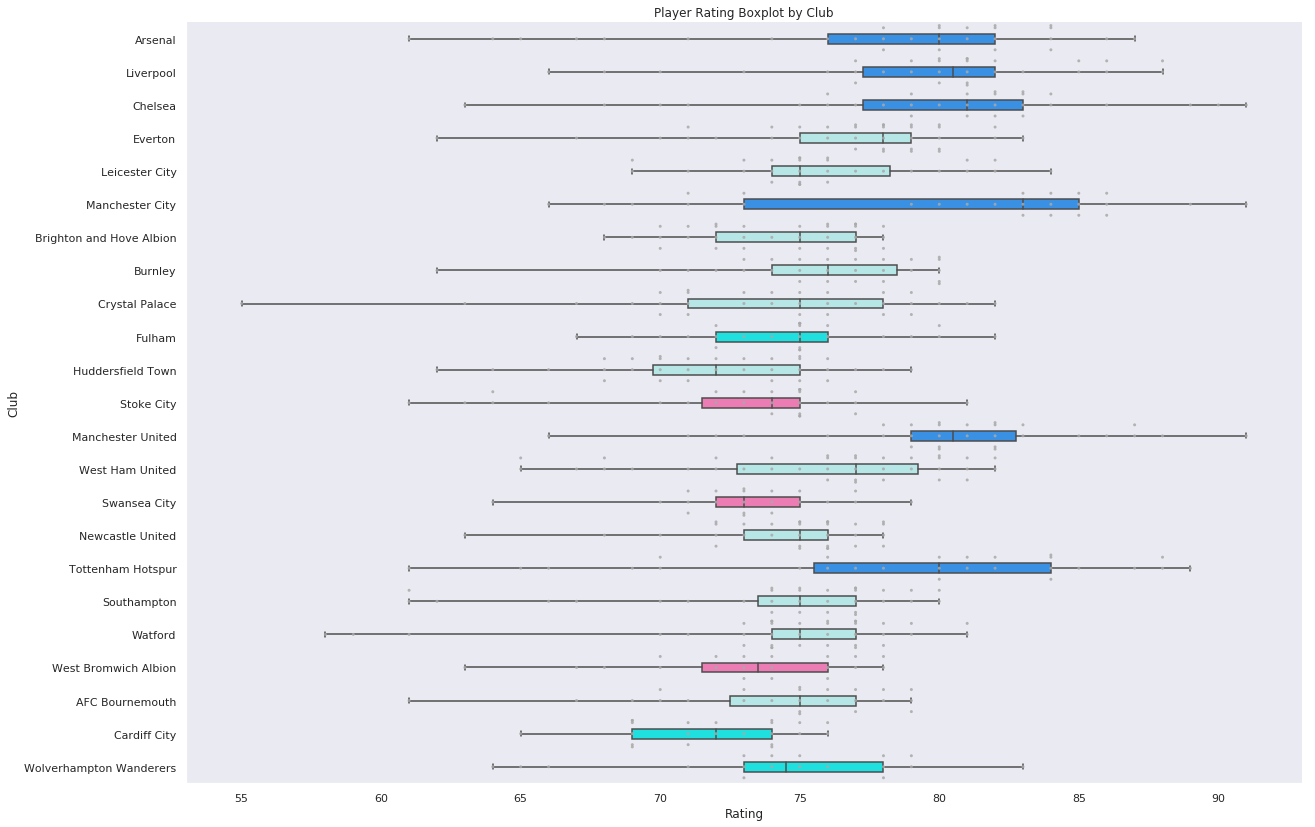

In [14]:
big_six = ["Arsenal", "Liverpool", "Chelsea", "Tottenham Hotspur", "Manchester United", "Manchester City"]
promoted = ["Fulham", "Wolverhampton Wanderers", "Cardiff City"]
relegated = ["Stoke City", "Swansea City", "West Bromwich Albion"]

my_pal = {club: "dodgerblue" if club in big_six else "hotpink" if club in relegated else "aqua" if club in promoted else "paleturquoise"  for club in player_ratings.CLUB.unique()}

ax_players = plt.subplot()
ax_players = make_swarmplot(player_ratings,"RATING","CLUB",ax_players,box_pal=my_pal)
ax_players.set_title("Player Rating Boxplot by Club")

How will these ratings help?

I am basically trying to estimate the probability of a match outcome conditional on the difference in average rating between two teams. In (my best attempt at) math:

<p style="text-align: center;">Let <b>Y</b> ~ the outcome of a game <br></p>
<p style="text-align: center;"><b>Y</b> can take values in the set {win, draw, loss}</p>

<p style="text-align: center;">Let <b>D</b> ~ the absolute difference in rating between two teams <br></p>
<p style="text-align: center;"><b>D</b> can take on any real value <b>d</b> in  [0,100]</p>

I want to estimate $P(Y | D = d)$ <br>

So the next thing I do is compute the average rating for both the home and away team for every match played in the 2017/18 season and then take the difference. These differences are appended to the dataframe. The two functions that do this are in the cell below. The function call is in the cell that follows.

In [15]:
# these functions compute the rating averages for teams, the differences, and append them to the match data dataframes 

def compute_team_average(names ,ratings ):
    """This function computes the average rating for a list of players. It accounts for any empty
    strings (i.e. '') in the list.
    
    :param: list names : A list of names of the players.
    :param: DataFrame ratings : An appropriately formatted dataframe containing player ratings.
    :return: The average rating of the players passed in.
    :rtype: float
    
    """
    
    #initialize return variable
    average = 0  
    count = 0 
    
    # only count players who actually appeared, ignore empty places and NaN values
    for name in names:
        if type(name) == str:
            average = average + ratings[ratings["NAME"]==name.strip()]["RATING"].min()
            count = count + 1
            
    # average contains the sum of all player ratings, thus divide
    average = average/count
    
    return average


def add_averages_to_df(match_data,ratings):
    """This function appends the following three coloumns to the match data dataframe:
    home_team_rating, away_team_rating, rating_diff. It returns this modified dataframe.
    
    :param: DataFrame match_data: This dataframe must contain the lineups for each game in the set.
    :param: DataFrame ratings: This dataframe must contain player ratings.
    :return: Appends three columns to the match_data dataframe: one for the average rating for the home team,
            one for the average rating for the away team, and a column for the average difference.
    :rtype: DataFrame        
    
    """

    # initialize lists to store the home team average rating, away team average rating, and average team difference
    home_team_rating = []
    away_team_rating = []
    average_rating_diff =[]
    
    # populate the above list by match
    for i in match_data.index:
        home_team_rating.append(compute_team_average(list(match_data.iloc[i][6:20]), ratings))
        away_team_rating.append(compute_team_average(list(match_data.iloc[i][20:34]), ratings))
        average_rating_diff.append(home_team_rating[i] - away_team_rating[i])
        
    # turn the three lists into series
    home_average_series = pd.Series(home_team_rating)
    away_average_series = pd.Series(away_team_rating)
    average_rating_diff = pd.Series(average_rating_diff)
    
    # append the series as columns into the dataframe
    match_data["home_average_rating"] = home_average_series
    match_data["away_average_rating"] = away_average_series
    match_data["rating_diff"] = average_rating_diff
    
    return match_data

In [16]:
# function calls to compute averages, find differences
rating_games_2018 = add_averages_to_df(match_data_2018, player_ratings)
rating_games_2019 = add_averages_to_df(match_data_2019, player_ratings)
rating_games_2018.head()

match_id                 home_team          away_team  home_goals  \
0     22342                   Arsenal     Leicester City           4   
1     22343  Brighton and Hove Albion    Manchester City           0   
2     22344                   Chelsea            Burnley           2   
3     22345            Crystal Palace  Huddersfield Town           0   
4     22346                   Everton         Stoke City           1   

   away_goals  result        home_player1           home_player2  \
0           3       1          Petr Cech         Sead Kolasinac    
1           2      -1           Mat Ryan             Lewis Dunk    
2           3      -1   Thibaut Courtois        Antonio Rudiger    
3           3      -1    Wayne Hennessey    Timothy Fosu-Mensah    
4           0       1    Jordan Pickford          Phil Jagielka    

        home_player3       home_player4  ...       away_player8  \
0       Rob Holding      Nacho Monreal   ...     Wilfred Ndidi    
1    Markus Suttner        Shane Duffy   ...   Kevin De Bruyne    
2        David Luiz        Gary Cahill   ...     Steven Defour    
3        Scott Dann    Jairo Riedewald   ...      Kasey Palmer    
4   Ashley Williams      Michael Keane   ...         Joe Allen    

       away_player9      away_player10     away_player11  \
0     Riyad Mahrez     Shinji Okazaki       Jamie Vardy    
1           Danilo      Sergio Aguero     Gabriel Jesus    
2        Jack Cork          Sam Vokes     Jeff Hendrick    
3   Philip Billing         Aaron Mooy      Steve Mounie    
4            Bojan    Xherdan Shaqiri    Saido Berahino    

                away_player12       away_player13        away_player14  \
0             Daniel Amartey        Demarai Gray    Kelechi Iheanacho    
1             Bernardo Silva          Leroy Sane      Raheem Sterling    
2              Scott Arfield    Jonathan Walters                   NaN   
3         Rajiv van La Parra      Danny Williams        Collin Quaner    
4   Eric Maxim Choupo-Moting        Peter Crouch                   NaN   

  home_average_rating away_average_rating rating_diff  
0           80.357143           77.714286    2.642857  
1           74.928571           82.357143   -7.428571  
2           82.285714           77.307692    4.978022  
3           76.384615           73.000000    3.384615  
4           76.785714           75.692308    1.093407  

[5 rows x 37 columns]

The graphs below show the distribution of rating differences for both seasons. The difference in rating is calculated is $D = \overline{R_{home}} - \overline{R_{away}}$ where $\overline{R}$ is the average rating. Very high negative and very positive often arise from the same teams playing each other home and away. For example, when Stoke City played Chelsea away, $D=10.65$. In the reverse fixture, $D= -8.02$. That explains the symmetry of the graph.

The graph also shows that the distribution of average differences this season is quite similar to last season's.

Text(0.5, 0.98, 'Differences in Average Ratings Across Seasons')

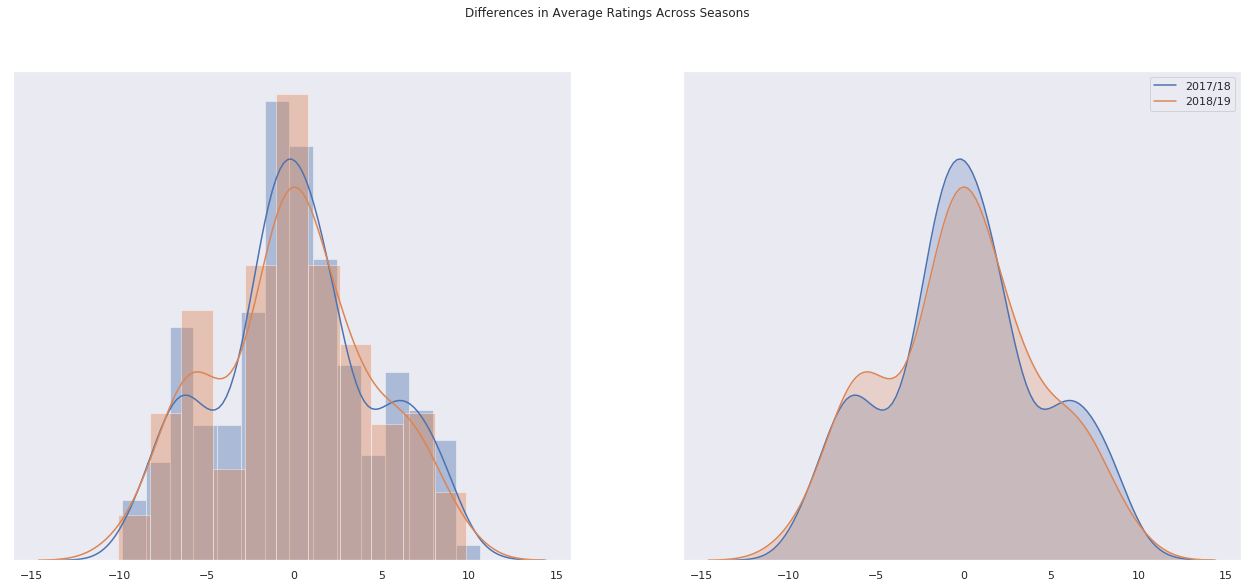

In [17]:
# create figure
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey=True, sharex = True)
axes[0].figure.set_size_inches(22,9)

# plot each histogram in turn
for data,label in zip([rating_games_2018["rating_diff"],rating_games_2019["rating_diff"]],['2017/18','2018/19']):
    axes[0] = sns.distplot(data, hist = True, ax = axes[0], label= label)
    axes[1] = sns.distplot(data, hist=False, kde = True,kde_kws={"shade": True}, ax = axes[1], label= label)

# remove x labels
axes[0].set_xlabel('')
axes[1].set_xlabel('')

# remove grids
axes[0].grid(False)
axes[1].grid(False)

# remove y axis
axes[0].get_yaxis().set_visible(False)

# set graph title
fig.suptitle("Differences in Average Ratings Across Seasons")

I estimate the conditional distribution of outcomes by binning the differences from the 2017/18 season. Then for each bin, I count the number of matches that fall into it, $k$, and then classify each result as a win, draw, or loss for the higher rated team. The probability of an outcome in a given bin is the number of occurances of a specific outcome (win, loss, or draw) divided by $k$. The two functions below carry this out. 

In [18]:
def estimate_conditional_pdf(data, count):
    """This function estimates the conditional probability of one bin in the conditional pdf.
    
    :param DataFrame data: Data frame that satisfies: lower_bound <= rating_diff <= upper_bound.
    :param int count: Number or rows in this dataframe.
    :return: Returns the following three floats: p(win), p(draw), p(loss).
    :rtye float, float, float
    
    """
    
    # count the number of wins 
    # home team wins, home team is higher rated OR away team  wins, away team is higher rated
    wins =  data[data["result"]==1][data["rating_diff"]>0]["rating_diff"].count() 
    wins = wins +  data[data["result"]==-1][data["rating_diff"]<0]["rating_diff"].count()  
    # count the number of draws
    draws = data[data["result"]==0]["rating_diff"].count() # ties
    
    # count the number of losses
    # home team wins, away team is highe rated OR away team wins, home team is higher rated  
    losses = data[data["result"]==1][data["rating_diff"]<0]["rating_diff"].count()  
    losses = losses + data[data["result"]==-1][data["rating_diff"]>0]["rating_diff"].count() 
    
    return wins/count, draws/count, losses/count
    


def estimate_full_conditional_pdf(data, _max, _bins):
    """This function estimates full conditional pdf given data, max differences, and the number of bins (_bins).
    
    :param DataFrame data: The match data dataframe.
    :param float _max: The maximum rating difference between two teams in any game played and part of the data dataframe parameter.
    :param int _bins: The number of bins to be used create the conditional distribution.
    :return: Returns a dataframe containing the conditional pdf.
    :rtype: DataFrame
    
    """
    
    columns = ["Difference","Win", "Draw", "Loss", "Count","Min","Max", "Sum"]
    index = range(_bins)

    pdf = pd.DataFrame(index = index, columns = columns)  
    
    bin_width = _max/_bins
    lower_bound = 0
    upper_bound = bin_width
    
    # creat bins, estimate pdf for each bin in turn
    for i in index:
        # obtain number of rows in bin
        count = data[data["rating_diff"].apply(abs) < upper_bound]\
                [data["rating_diff"].apply(abs) >= lower_bound]["rating_diff"].count()
        
        # deals with zero difference
        if i ==0:
            count= count-data[data["rating_diff"]==0]["rating_diff"].count()
        
        # calculate pdf for => rating difference in [lower_bound, upper_bound]
        p_win, p_draw, p_loss = estimate_conditional_pdf(data[data["rating_diff"].apply(abs) < upper_bound]\
                                                   [data["rating_diff"].apply(abs) >= lower_bound], count)
        
        # update pdf table row
        pdf.loc[i]["Difference"] = "(" + str(lower_bound) + ", " +str(upper_bound)+"]"
        pdf.loc[i]["Win"] = p_win
        pdf.loc[i]["Draw"] = p_draw
        pdf.loc[i]["Loss"] = p_loss
        pdf.loc[i]["Count"] = count
        pdf.loc[i]["Min"] = lower_bound
        pdf.loc[i]["Max"] = upper_bound
        pdf.loc[i]["Sum"] = p_win+p_draw+p_loss
        
        # update bounds
        lower_bound = lower_bound + bin_width
        upper_bound = upper_bound + bin_width
        
    return pdf
            

The parameter I have the most control over when trying to estimate the conditional pdf is the number of intervals and, consequently, the interval width. This determines how accurate the estimate is going to be. Since I have just 380 data points in my training set, having very small intervals could result in a lot of empty bins. Having intervals that are too large would miss the point entirely and offer no precision at all. Since the relationship between interval size and accuracy is arguably nonmonotonic, I will estimate several conditional pdfs and then pick out whichever one predicts the most match outcomes correctly for this season. 

The next cell finds 22 conditional pdfs. The minimum interval width I set is 0.5 and the maximum interval widths is 11. This is somewhat arbitrary but having smaller widths would result in empty intervals.

In [19]:
_max = abs(max(match_data_2018["rating_diff"].agg(["min","max"]), key = abs))
pdf = []
for num in np.arange(math.ceil(_max)*2):
    pdf.append(estimate_full_conditional_pdf(rating_games_2018,math.ceil(_max),num+1))

This is the pdf when the interval width is 1. The sum column is a check to make sure that the probabilities add to 1. 

In [20]:
pdf[10][["Difference","Win","Draw","Loss","Count","Sum"]]

Difference       Win      Draw       Loss Count Sum
0       (0, 1.0]  0.444444  0.283951   0.271605    81   1
1     (1.0, 2.0]  0.407407  0.320988   0.271605    81   1
2     (2.0, 3.0]  0.487805  0.365854   0.146341    41   1
3     (3.0, 4.0]  0.592593  0.185185   0.222222    27   1
4     (4.0, 5.0]       0.5  0.363636   0.136364    22   1
5     (5.0, 6.0]  0.766667       0.2  0.0333333    30   1
6     (6.0, 7.0]   0.72093  0.139535   0.139535    43   1
7     (7.0, 8.0]  0.652174  0.217391   0.130435    23   1
8     (8.0, 9.0]  0.782609  0.130435  0.0869565    23   1
9    (9.0, 10.0]  0.714286  0.285714          0     7   1
10  (10.0, 11.0]         1         0          0     1   1

For any of these pdfs to be acceptable, they have to at least do better than completely random <br>
guessing, i.e. guessing $p($win$) = p($draw$) = p($loss$)=1/3$. This is shown below.

In [21]:
random_pdf = pdf[0].copy()
for outcome in ["Win","Draw", "Loss"]: 
    random_pdf[outcome] = random_pdf.replace(to_replace='.', value=1/3, regex=True)
random_pdf

Difference       Win      Draw      Loss Count Min Max Sum
0  (0, 11.0]  0.333333  0.333333  0.333333   379   0  11   1

The next step is to test these pdfs in turn. I use the data from this season to do that. This testing dataset has 190 points. I know what the lineups are for these games so I can compute the difference in average rating for each of them.

The two functions below use the pdf function and the difference in rating to simulate a set of games. So they will basically draw from a uniform distribution and compare the draw to the pdf function to determine an outcome.

Since I know what the result for each game is, each pdf gets a score based on how many results it guesses correctly. 

In [22]:
# extract appropriate probabiilities for a single game
def simulate_single_game(data, pdf):
    """Simulates a single game based on the conditional pdf of matching outcomes on rating differences.
    
    :param DataFrame data: The dataframe row of relevent game.
    :param DataFrame pdf: The dataframe containing the conditional pdf.
    :return: Returns 1 for a home win, -1 for an away win, and zero for a draw.
    :rtype: int
    
    """
    
    difference = data[0]
    u = data[1]
    
    # extract appropriate probabiilities for the game based on the difference
    # i.e. pick out the relevant row of the full pdf
    for i in pdf.index:
        if abs(difference) >=pdf["Min"][i] and abs(difference) < pdf["Max"][i]:
            p_win, p_draw, p_loss = pdf["Win"][i] , pdf["Draw"][i] , pdf["Loss"][i]

    # determine simulated result based on u (a random draw from unif(0,1))
    if u <= p_win:
        if difference > 0 :
            result = 1
        else:
            result = -1
    elif p_win < u <= p_win+p_draw:
        result = 0
    else:
        if difference > 0:
            result = -1
        else:
            result = 1

    return result

def simulate_games(data, pdf):
    """ Simulates all games by making calls to simulate_single_game based on the conditional pdf of matching outcomes on rating differences.
    
    :param DataFrame data: The dataframe row of relevent game.
    :param DataFrame pdf: The dataframe containing the conditional pdf.
    :return: Adds a column to the data dataframe that contains the simulated result.
    :rtype: DataFrame
    
    """
    
    return_df = data.copy()

    # set seed, 42 because of the hitch-hikers guide to the galaxy
    np.random.seed(42)

    # generate ranndom numbers to help simulate each match
    num_matches = len(return_df.index)
    U = np.random.uniform(0,1,num_matches)

    # add random numbers to dataframe
    return_df["U"] = pd.Series(U)

    # simulate all the games
    return_df["simulated_result"] = return_df[["rating_diff","U"]].apply(func=simulate_single_game, pdf= pdf,axis=1)
    
    # remove the U column
    return_df = return_df.drop("U", axis=1)
    
    return return_df

# checks how many times the simulated result equalled the actual result
def score_simulation(data):
    """ This function scores the simulation results. It does this by comparinng the simuulated result to the actual results. The score is equal to the 
    number of matches correctly predicted by the simulation.
    
    :param DataFrame data: A dataframe containing match data and the simulated results for every game.
    :return: The score for the simulation. This is equal to the number of times the simulated result equals the actual/observed results.
    :rtype: int
    
    """
    return data[data["result"]==data["simulated_result"]].count().max()

The next cell computes the score for each pdf I chose to test. The best performing pdfs are shown right after.

In [23]:
scores = []
for i in range(len(pdf)):
    scores.append(score_simulation(simulate_games(match_data_2019,pdf[i])))

random_guess_score = score_simulation(simulate_games(match_data_2019,random_pdf))

In [24]:
num_bins = np.arange(math.ceil(_max)*2)+1
bin_widths = math.ceil(_max)/num_bins
bin_score_info = pd.DataFrame({"Bins":num_bins, "Bin Width":bin_widths, "Score":scores})
bin_score_info[bin_score_info["Score"]==bin_score_info["Score"].max()]

Bins  Bin Width  Score
15    16   0.687500     90
16    17   0.647059     90
18    19   0.578947     90

In [25]:
random_guess_score

72

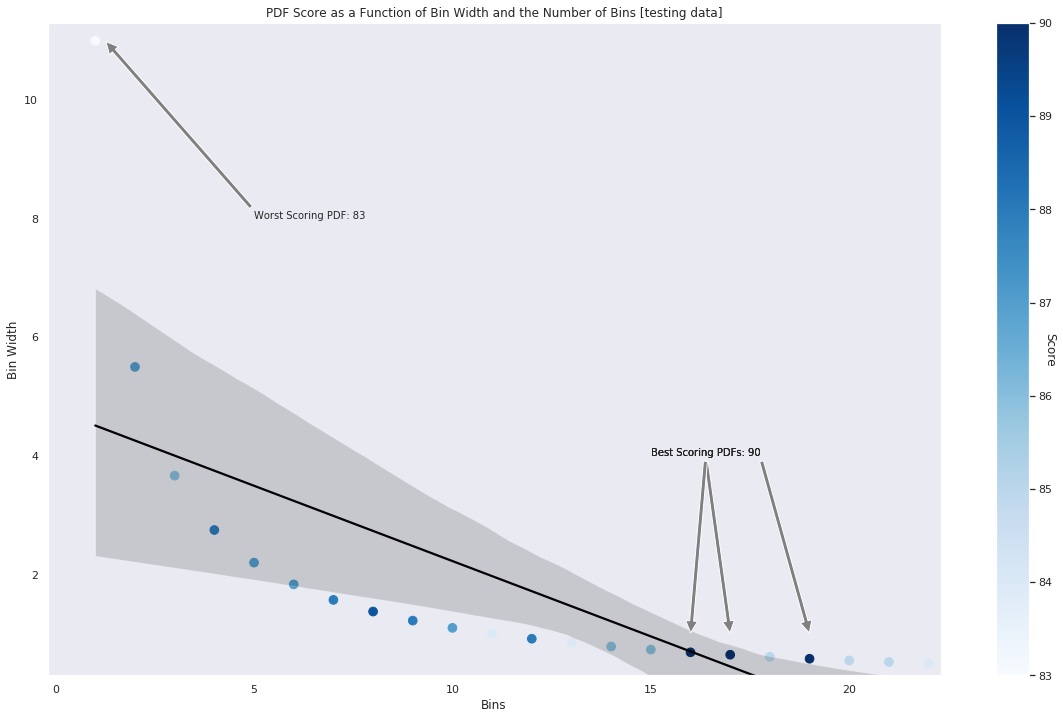

In [26]:
def plot_pdf_scores(bin_score_info, title=''):
    """This function produces a plot relating bin width, the  number of bins, and the scores for each pdf etimate on a single figure.
    
    :param DataFrame bin_score_info: The scores for each simulation/pdf result.
    :param str title: The title for the plot.
    :return: Returns an axes object with the plot on it.
    :rtype: Axes
    
    """
    
    # create scatter points
    points = plt.scatter(bin_score_info["Bins"], bin_score_info["Bin Width"],
                         c=bin_score_info["Score"], s=75, cmap="Blues")

    # create color map
    cbar = plt.colorbar(points)
    cbar.set_label("Score", rotation=270)
    # set limit
    plt.gca().set_xlim([0-0.2,22.3])
    plt.gca().set_ylim([0.3,11+0.3])
    
    # set titles
    plt.gca().set_title("PDF Score as a Function of Bin Width and the Number of Bins" + title)
    plt.gca().grid(False)
    
    # do regression 
    ax_scores = sns.regplot("Bins", "Bin Width", data=bin_score_info, scatter=False, color=".01",truncate=True)

    # set size
    ax_scores.figure.set_size_inches(20,12)

    return ax_scores

ax_scores = plot_pdf_scores(bin_score_info, ' [testing data]')

for arrow_coord in [(19, 1),(17, 1),(16, 1)]:
    plt.gca().annotate('Best Scoring PDFs: 90', xy=arrow_coord, xytext=(15, 4),
                arrowprops=dict(facecolor='grey', shrink=0.005),
                )

plt.gca().annotate('Worst Scoring PDF: 83', xy=(1.25,11), xytext=(5, 8),
            arrowprops=dict(facecolor='grey', shrink=0.005),
            )

plt.gca().set_xticks([0,5,10,15,20])

The graph above shows the scores for the pdf against the number of bins and bin width. Like I suspected, the relationship between those two factors and the score is not monotonic. The maximum score occurs at $n_{bins}$=$[16, 17, 19]$. Unsurprisingly, the worst score corresponds to zero bins where we do no conditioning at all. All the scores are higher than the purely random score which is $72$.

The graph below show the same graph for the training dataset.


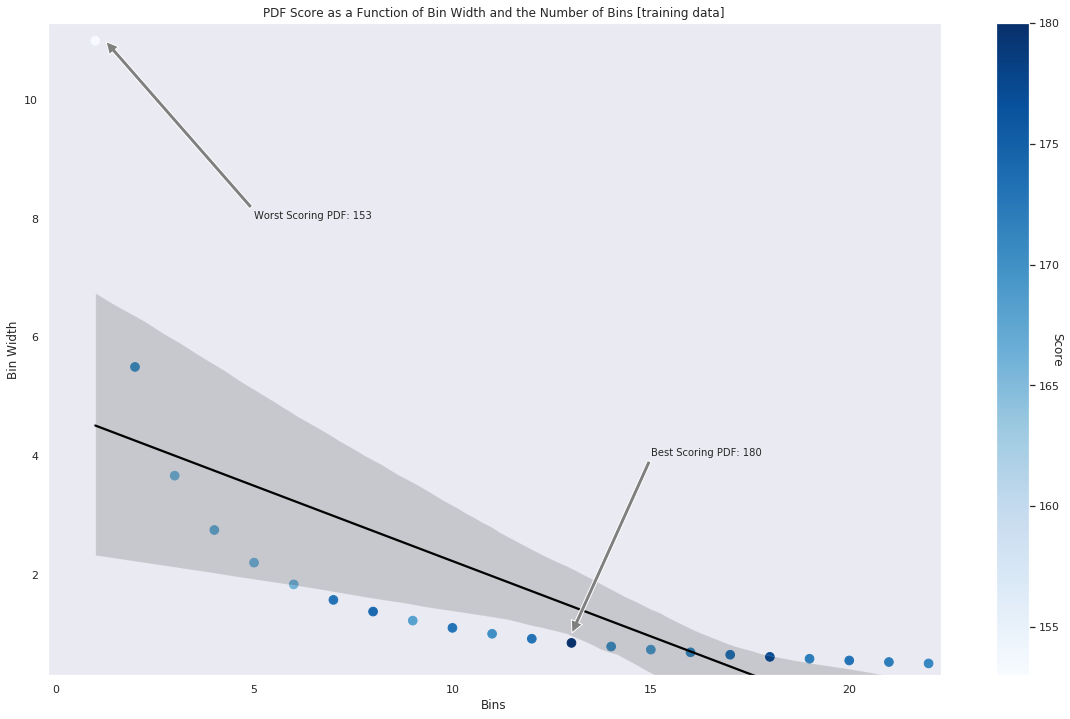

In [27]:
scores_train = []
for i in range(len(pdf)):
    scores_train.append(score_simulation(simulate_games(match_data_2018,pdf[i])))
    
num_bins_train = np.arange(math.ceil(_max)*2)+1
bin_widths_train = math.ceil(_max)/num_bins_train
bin_score_info_train = pd.DataFrame({"Bins":num_bins_train, "Bin Width":bin_widths_train, "Score":scores_train})
bin_score_info_train[bin_score_info_train["Score"]==bin_score_info_train["Score"].max()]

ax_scores_train = plot_pdf_scores(bin_score_info_train, " [training data]")

for arrow_coord in [(13, 1)]:
    plt.gca().annotate('Best Scoring PDF: 180', xy=arrow_coord, xytext=(15, 4),
                arrowprops=dict(facecolor='grey', shrink=0.005),
                )

plt.gca().annotate('Worst Scoring PDF: 153', xy=(1.25,11), xytext=(5, 8),
            arrowprops=dict(facecolor='grey', shrink=0.005),
            )

plt.gca().set_xticks([0,5,10,15,20])

The graph below plots all the PDFs against the difference in player ratings. The three estimates that got the highest scores after the simulation are in bold while all the other estimates are lightly visible in the background.

In [28]:
def format_pdf_for_plot(pdfs, outcome ):
    """This function creates a dataframe that has rows that correspond to the probability of an outcome
    vs the difference in average rating.
    
    :param list pdfs: A list containing all the pdf estimates. Every element in the list is a dataframe.
    :param str outcome: The outcome to focus on: "Win", "Draw", "Loss"
    :return: Probability of outcome vs difference for every pdf, each row corresponds to pdf
    :rtype: DataFrame
    
    """

    out_list = []
    
    for pdf in pdfs:
        q = np.linspace(0,1,len(pdfs))
        for i in pdf.index:
            q[math.floor(pdf["Min"][i]*2):math.ceil(pdf["Max"][i])*2]  = pdf[outcome][i]
        out_list.append(q)
        
    out_df = pd.DataFrame(out_list)
    
    return out_df



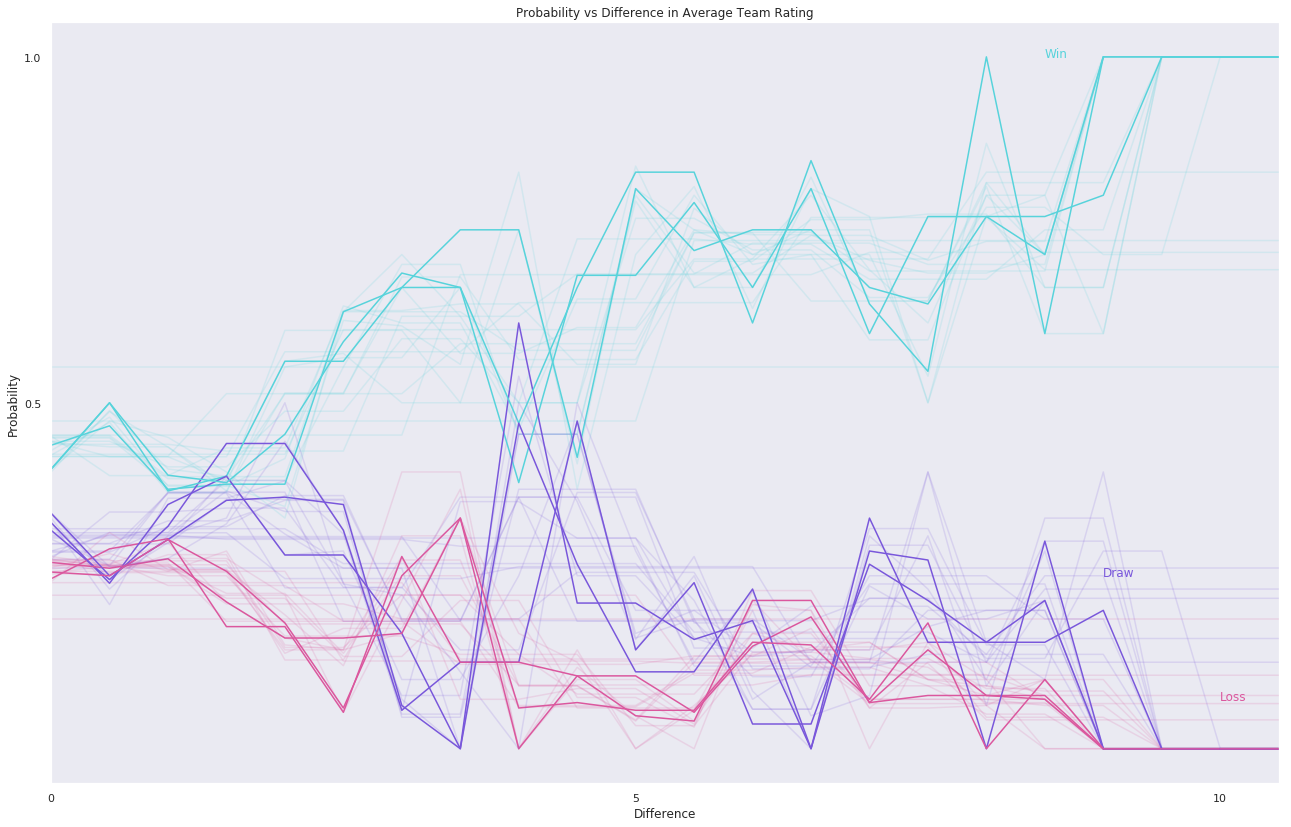

In [29]:
wins = format_pdf_for_plot(pdf, "Win")
draws = format_pdf_for_plot(pdf, "Draw")
losses = format_pdf_for_plot(pdf, "Loss")

new_columns = dict(zip(np.arange(22),np.arange(22)/2))

wins = wins.rename(columns = new_columns)
wins = wins.rename(new_columns, axis='index')
losses = losses.rename(columns = new_columns)
losses = losses.rename(new_columns, axis='index')
draws = draws.rename(columns = new_columns)
draws = draws.rename(new_columns, axis='index')

ax_pdf = plt.subplot()

n_bins = [16/2, 17/2, 19/2]
for i in np.arange(22)/2:
    if i in n_bins:
        wins.loc[i].plot("line", color =sns.hls_palette(10)[5], ax =ax_pdf )
        draws.loc[i].plot("line", color =sns.hls_palette(10)[7], ax =ax_pdf)
        losses.loc[i].plot("line", color =sns.hls_palette(10)[9], ax =ax_pdf)
    else:
        wins.loc[i].plot("line", color =sns.hls_palette(10)[5], ax =ax_pdf, alpha =0.16)
        draws.loc[i].plot("line", color =sns.hls_palette(10)[7], ax =ax_pdf, alpha =0.16)
        losses.loc[i].plot("line", color =sns.hls_palette(10)[9], ax =ax_pdf, alpha =0.16)

ax_pdf.grid(False)
ax_pdf.figure.set_size_inches(22,14)

ax_pdf.set_xlabel('Difference')
ax_pdf.set_ylabel('Probability')

ax_pdf.set_xticks([0,5,10])
ax_pdf.set_yticks([0.5,1])

ax_pdf.set_title("Probability vs Difference in Average Team Rating")

for title,text_coord, color in zip(["Win", "Draw", "Loss"],[(17/2,1),(18/2,0.25),(20/2, 0.07)],[sns.hls_palette(10)[5],sns.hls_palette(10)[7],sns.hls_palette(10)[9]]):
    plt.gca().text(text_coord[0], text_coord[1], title, color = color, fontsize=12)


As the difference in team rating increases, the probability of winning consistently increases. This graph is basically the conditional distribution I set out to find in the first place. This is much easier to interpret than the tables I showed before.

### Conclusion

While the estimation results are not particularly predictive, they are better than guessing at random. The web scraping part of the code works very well though. I intend to use it to produce a more complete dataset of Premier League matches and results for the past 27 years of the competition and all I need are the match IDs for those games. 